<a href="https://colab.research.google.com/github/435wldms/essa/blob/main/20230522_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

**LinearRegression 클래스 - Ordinary Least Squares**

* LinearRegression은 fit() 매서드로 X,y 배열을 입력 받으면 회귀 계수를 coef_ 속성에 저장

In [ ]:
# class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

* 다중 공선성 문제 : 피처 간의 상관관계가 매우 높은 경우 분산이 매우 커져서 오류에 민감함

**회귀 평가 지표**

* MAE : 실제 값과 예측 값 차이의 절대값 합의 평균
* MSE : 실제 값과 예측 값 차이의 제곱의 평균
* RMSE : MSE에 루트 씌운 값
* R^2 : 실제 값의 분산 대비 예측 값의 분산 비율, 1에 가까울수록 정확
* 원래 위의 값들은 음수가 될 수 없는데 실제 함수에 neg_mean_squared_error와 같이 'neg'를 불여서 사용하는 이유는 사이킷런의 Scoring 함수가 값이 클수록 좋은 평가 결과로 자동 평가하기 때문 -> 원래 평가 지표의 경우 클 수록 나쁜 모델이므로 자체적으로 음수로 변환

**LinearRegression을 이용해 보스턴 주택 가격 회귀 구현**

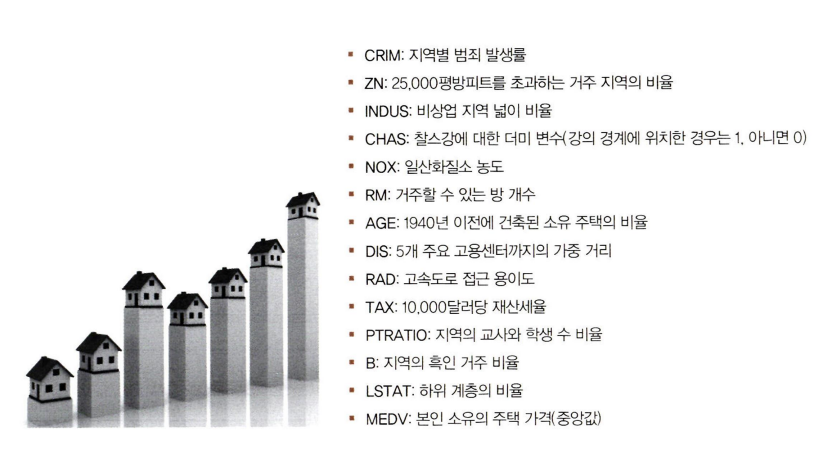

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(data, columns=['CRIM','ZN','INDUS','CHAS', 'NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'])

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함.
bostonDF['PRICE']= pd.DataFrame(target, columns=['MEDV'])
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


-> Null값은 없고 모두 float형

* 각 칼럼이 회귀 결과에 미치는 영향이 어느 정도인지 시각화하여 알아봄

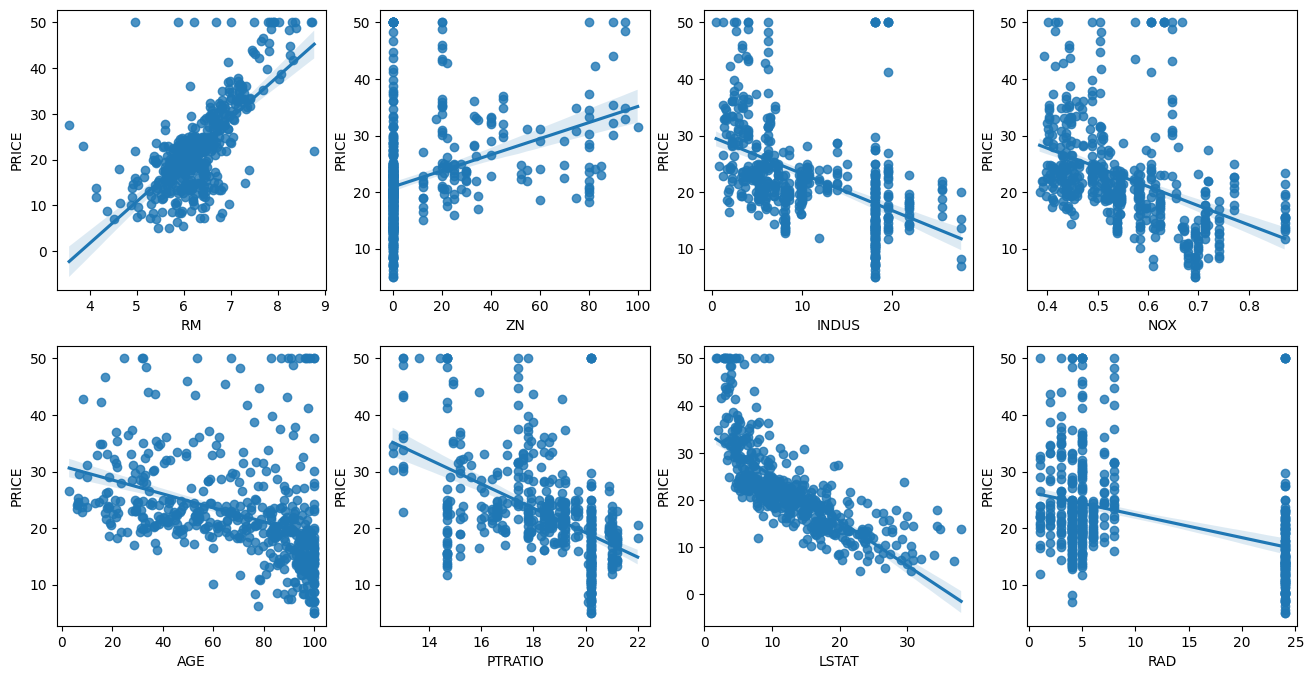

In [ ]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. ax는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8),ncols=4, nrows=2)
lm_features = ['RM','ZN','INDUS', 'NOX','AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
  row = int(i/4)
  col = i%4
  # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
  sns.regplot(x=feature, y='PRICE',data=bostonDF, ax=axs[row][col])

-> 결과: RM, LSTAT의 PRICE 영향도가 가장 두드러지게 나타남, RM은 양방향, LSTAT은 음방향의 선형성이 가장 큼

* LinearRegression 클래스를 이용해 보스턴 주택 가격의 회귀 모델 생성
* mean_squared_error(), r2_score() API를 이용해 측정

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data,y_target,test_size=0.3,random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test,y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse,rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test,y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [ ]:
print('절편 값 :',lr.intercept_)
print('회귀 계수 값 :',np.round(lr.coef_,1))

절편 값 : 40.995595172164826
회귀 계수 값 : [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


* 회귀 계수 값을 피처 별 회귀 계수 값으로 매핑 & 높은 순으로 출력

In [ ]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_,1),index = X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

* 5 개의 폴드 세트에서 cross_val_score()를 이용해 교차 검증으로 MSE, RMSE를 측정(단, scoring이므로 neg 붙이기)

In [ ]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1, inplace=False)
lr = LinearRegression()

# cross_val_score()로 5 폴드 세트로 MSE 를 구한 뒤 이를 기반으로 다시 RMSE 구함.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring='neg_mean_squared_error',cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print(' 5 folds의 개별 Negative MSE scores:',np.round(neg_mse_scores,2))
print(' 5 folds의 개별 RMSE scores:',np.round(rmse_scores,2))
print(' 5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 folds의 개별 Negative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds의 개별 RMSE scores: [3.53 5.1  5.75 8.99 5.77]
 5 folds의 평균 RMSE : 5.829
